## Goals:
1) Chatbot with profile schema
2) For Complex Schema use `TrustCall` - Intro and an example
3) Chatbot with profile schema updating \w trustcall
4) Chatbot with Collection Schema instead of profile - For more flexibility using `Pydantic`

In [1]:
from typing import TypedDict, Annotated
from IPython.display import display, Image
from dotenv import load_dotenv

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage, RemoveMessage, AnyMessage, merge_message_runs
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.config import RunnableConfig

from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore
from langgraph.store.base import BaseStore

import uuid

In [2]:
load_dotenv()

True

In [3]:
model = ChatOpenAI(
    model="/gpfs/projects/bsc02/llm_models/huggingface_models/Qwen3-32B",
    openai_api_key="dummy",  # vLLM doesn't need a real key
    openai_api_base="http://localhost:8002/v1",  # Your forwarded port
    temperature=0.7,
    max_tokens=500
)

In [4]:
class UserProfile(TypedDict):
    """User profile schema with typed fields"""
    user_name: str        # The user's preferred name
    interests: list[str]  # A list of the user's interests

In [5]:
# TypedDict instance
user_profile: UserProfile = {
    "user_name": "Lance",
    "interests": ["biking", "technology", "coffee"]
}
user_profile

{'user_name': 'Lance', 'interests': ['biking', 'technology', 'coffee']}

In [6]:
# Initialize the in-memory store
in_memory_store = InMemoryStore()

# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memory")

# Save a memory to namespace as key and value
key = "user_profile"
value = user_profile
in_memory_store.put(namespace_for_memory, key, value)

In [8]:
# Search 
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'namespace': ['1', 'memory'], 'key': 'user_profile', 'value': {'user_name': 'Lance', 'interests': ['biking', 'technology', 'coffee']}, 'created_at': '2026-02-24T10:54:30.253843+00:00', 'updated_at': '2026-02-24T10:54:30.253848+00:00', 'score': None}


In [9]:
# Get the memory by namespace and key
profile = in_memory_store.get(namespace_for_memory, "user_profile")
profile.value

{'user_name': 'Lance', 'interests': ['biking', 'technology', 'coffee']}

## Chatbot with profile schema
- Basically LLM `StructuredOutput`
- modeling a distributed, namespaced memory hierarchy under the hood.


In [10]:
# Bind schema to model
model_with_structure = model.with_structured_output(UserProfile)

In [11]:
# Invoke the model to produce structured output that matches the schema
structured_output = model_with_structure.invoke([HumanMessage("My name is Lance, I like to bike.")])
structured_output

{'user_name': 'Lance', 'interests': ['biking']}

In [11]:
# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

In [12]:
# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """Create or update a user profile memory based on the user's chat history. 
This will be saved for long-term memory. If there is an existing memory, simply update it. 
Here is the existing memory (it may be empty): {memory}"""


The function `call_model` is designed to:

- `Load the user’s stored memory, use it to personalize the system prompt, and then generate a response from the model that blends both past memory and current messages.`

- It’s a micro-agent callback that bridges:
  - The `store layer` (long-term or cross-session memory),
  - The `state layer` (current chat context),
  - The `model invocation layer`.

In [13]:
def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"] # scope key for personalized memory.

    # Retrieve memory from the store
    '''
        {
      ("memory", "user_123"): {
          "user_memory": {
              "user_name": "John",
              "interests": ["AI", "Robotics", "LangGraph"]
          }
      }
    }
    '''
    namespace = ("memory", user_id) ## It means find inside memory/user_id/user_memory
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None
        
    # Format the existing memory in the instruction
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=formatted_memory)

    # Invoke the model to produce structured output that matches the schema
    new_memory = model_with_structure.invoke([SystemMessage(content=system_msg)]+state['messages'])

    # Overwrite the existing use profile memory
    key = "user_memory"
    store.put(namespace, key, new_memory)

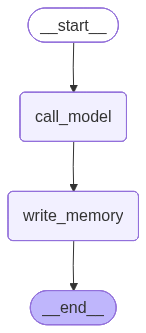

In [14]:
# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [16]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Lance and I like to bike around San Francisco and eat at bakeries. Where can I find an amazing croissant?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance and I like to bike around San Francisco and eat at bakeries. Where can I find an amazing croissant?
================================== Ai Message ==================================

<think>
Okay, the user is Lance again, and he's asking where to find an amazing croissant in San Francisco. He already mentioned his interests in biking and bakeries, so I should focus on bakeries that are known for their croissants and maybe even mention if they're near biking routes.

First, I remember that in the previous conversation, I suggested Tartine. They are well-known for pastries, so that's a good start. But maybe there are other places too. Let me think of other top bakeries in SF. La Boulange is another popular one, they have great croissants and are located in several places, including the Ferry Building. That's a good spot because the Ferry Building is a nice area to bike around. 

Also, ma

In [17]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.value

{'user_name': 'Lance',
 'interests': ['biking', 'San Francisco', 'bakeries', 'croissants']}

## For Complex Schema use `TrustCall`

In [19]:
from trustcall import create_extractor
from pydantic import BaseModel, Field

In [20]:
# Conversation
conversation = [HumanMessage(content="Hi, I'm Lance."), 
                AIMessage(content="Nice to meet you, Lance."), 
                HumanMessage(content="I really like biking around San Francisco.")]

In [21]:
# Schema 
class UserProfile(BaseModel):
    """User profile schema with typed fields"""
    user_name: str = Field(description="The user's preferred name")
    interests: list[str] = Field(description="A list of the user's interests")

# Initialize the model
model = model

# Create the extractor
trustcall_extractor = create_extractor(
    llm=model,
    tools=[UserProfile],
    tool_choice="UserProfile"
)

# Instruction
system_msg = "Extract the user profile from the following conversation"

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)] + conversation})

In [22]:
for m in result["messages"]: 
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (chatcmpl-tool-bfb9a2a320314dc8)
 Call ID: chatcmpl-tool-bfb9a2a320314dc8
  Args:
    user_name: Lance
    interests: ['biking around San Francisco']


In [23]:
schema = result["responses"]
schema

[UserProfile(user_name='Lance', interests=['biking around San Francisco'])]

In [24]:
schema[0].model_dump() # serialize a Pydantic model instance into a dict.

{'user_name': 'Lance', 'interests': ['biking around San Francisco']}

In [25]:
# Update the conversation
updated_conversation = [HumanMessage(content="Hi, I'm Lance."), 
                        AIMessage(content="Nice to meet you, Lance."), 
                        HumanMessage(content="I really like biking around San Francisco."),
                        AIMessage(content="San Francisco is a great city! Where do you go after biking?"),
                        HumanMessage(content="I really like to go to a bakery after biking."),]

# Update the instruction
system_msg = f"""Update the memory (JSON doc) to incorporate new information from the following conversation"""

# Invoke the extractor with the updated instruction and existing profile with the corresponding tool name (UserProfile)
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+updated_conversation}, 
                                    {"existing": {"UserProfile": schema[0].model_dump()}})  

In [26]:
for m in result["messages"]: 
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (chatcmpl-tool-96a73f97f3e6c334)
 Call ID: chatcmpl-tool-96a73f97f3e6c334
  Args:
    user_name: Lance
    interests: ['biking', 'bakery']


## Chatbot with `profile` schema updating \w trustcall

In [27]:
# Schema 
class UserProfile(BaseModel):
    """ Profile of a user """
    user_name: str = Field(description="The user's preferred name")
    user_location: str = Field(description="The user's location")
    interests: list = Field(description="A list of the user's interests")

In [28]:
# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile", # Enforces use of the UserProfile tool
)

In [29]:
# Chatbot system instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

In [30]:
# Extraction instruction
TRUSTCALL_INSTRUCTION = """Create or update the memory (JSON doc) to incorporate information from the following conversation:"""


In [31]:
def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Location: {memory_dict.get('user_location', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"      
        )
    else:
        formatted_memory = None

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")
        
    # Get the profile as the value from the list, and convert it to a JSON doc
    existing_profile = {"UserProfile": existing_memory.value} if existing_memory else None
    
    # Invoke the extractor
    result = trustcall_extractor.invoke({"messages": [SystemMessage(content=TRUSTCALL_INSTRUCTION)]+state["messages"], "existing": existing_profile})
    
    # Get the updated profile as a JSON object
    updated_profile = result["responses"][0].model_dump()

    # Save the updated profile
    key = "user_memory"
    store.put(namespace, key, updated_profile)

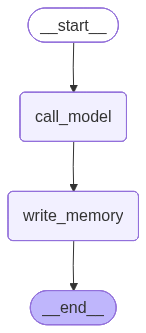

In [32]:
# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [33]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Lance")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

<think>
Okay, the user introduced himself as Lance. Since there's no existing memory for him, I need to start fresh. I should acknowledge his name and offer assistance. Let me make sure to keep the response friendly and open-ended to encourage him to ask questions or share more. Maybe add an emoji to keep it approachable. Also, I should check if there's anything specific he needs help with today. Alright, that should cover it.
</think>

Hi Lance! 👋 It's nice to meet you. How can I assist you today? Whether you have questions, need help with something specific, or just want to chat, I'm here for you! 😊


In [34]:
# User input 
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

<think>
Okay, the user mentioned they like to bike around San Francisco. Let me recall the previous conversation. The user's name is Lance, and now he's added that he enjoys biking in SF. I should update his profile with this information.

First, I need to acknowledge his interest in biking. Then, maybe provide some useful information or recommendations related to biking in San Francisco. Let me think about the best bike routes there. The Golden Gate Park is a popular spot, so that's a good suggestion. Also, the Presidio and the Marin Headlands might be worth mentioning for scenic routes. 

I should also consider safety tips since biking in a city can have its challenges. Maybe mention helmet laws and bike lanes. Additionally, bike rental options could be helpful if he's a visitor. Oh, and

In [35]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'namespace': ['memory', '1'],
 'key': 'user_memory',
 'value': {'user_name': 'Lance',
  'user_location': 'San Francisco',
  'interests': ['biking']},
 'created_at': '2026-02-24T12:32:02.342093+00:00',
 'updated_at': '2026-02-24T12:32:02.342096+00:00'}

In [36]:
# User input 
input_messages = [HumanMessage(content="I also enjoy going to bakeries")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I also enjoy going to bakeries
================================== Ai Message ==================================

<think>
Okay, let's see. The user mentioned they enjoy going to bakeries. I need to connect this with their previous interest in biking around San Francisco. Maybe they want to know bakeries that are accessible by bike.

First, I should list some popular bakeries in SF. Known names like Tartine, Bi-Rite, and maybe some local favorites. I should mention their locations to see if they're bike-friendly. Also, check if any have bike racks nearby.

I should highlight a few spots that are good for post-ride stops. Maybe include some details like what they're known for—like pastries, bread, or coffee. Also, check if any have outdoor seating for a quick rest after biking.

Need to make sure the information is up-to-date. Maybe mention if some bakeries have bike parking or if they're near bike routes. A

In [37]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="What bakeries do you recommend for me?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What bakeries do you recommend for me?
================================== Ai Message ==================================

<think>
Okay, the user is Lance, based in San Francisco, and he's interested in biking and bakeries. He asked for bakery recommendations. Let me start by recalling some popular or highly-rated bakeries in SF that I know of.

First, I should consider different neighborhoods since San Francisco is quite spread out. The Mission District is known for great food, so maybe Tartine Manufactory? That's a well-known spot for sourdough and pastries. Then there's the Ferry Building, which has the Boudin Bakery, famous for sourdough. The Fillmore area has Bi-Rite Creamery, which also does baked goods. Maybe include some in the Haight-Ashbury area, like La Boulange, which has a few locations. Oh, and in the Financial District, there's The Mill, which is a coffee and pastry place. 

I should also men

## Chatbot with `Collection` Schema instead of profile

- Instead of storing user information in a fixed profile structure, we'll create a flexible collection schema to store memories about user interactions.

- Each memory will be stored as a separate entry with a single content field for the main information we want to remember

- This approach allows us to build an open-ended collection of memories that can grow and change as we learn more about the user.

- We can define a collection schema as a Pydantic object.

### Advantage

- ✅ 1. Open-ended and dynamic

`You can add new types of memories without changing the structure.
Each new interaction becomes a new entry; the system can grow naturally.`

- ✅ 2. Easier retrieval and reasoning

`You can query the collection for specific types of memory:
memories_about_ai = [m for m in memory_collection if "AI" in m.content]`


Works naturally for vector-based retrieval or similarity search.

- ✅ 3. Better for multi-turn personalization

`Each memory entry can represent one fact, one interaction, or one observation.
Makes it easy to update, delete, or summarize without overwriting unrelated information.`

- ✅ 4. Time-awareness

`Each memory can have a timestamp (created_at), so you can track how user preferences evolve.
Enables recency-based retrieval — e.g., only consider memories from the last week.`

- ✅ 5. Schema enforcement with Pydantic

Using Pydantic ensures type safety and validation:
- `content is always a string`
- `timestamp is always datetime`
- `optional fields like category enforce consistent structure`

At the same time, you don’t hardcode all fields like a traditional fixed profile.

In [38]:
class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")

class MemoryCollection(BaseModel):
    memories: list[Memory] = Field(description="A list of memories about the user.")

In [39]:
# Bind schema to model
model_with_structure = model.with_structured_output(MemoryCollection)

# Invoke the model to produce structured output that matches the schema
memory_collection = model_with_structure.invoke([HumanMessage("My name is Lance. I like to bike.")])
memory_collection.memories

[Memory(content='My name is Lance. I like to bike.')]

In [45]:
memory_collection.memories[0].model_dump()
#memory_collection.memories[1].model_dump()

{'content': 'My name is Lance. I like to bike.'}

In [41]:
# Initialize the in-memory store
in_memory_store = InMemoryStore()

# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memories")

# Save a memory to namespace as key and value
key = str(uuid.uuid4())
value = memory_collection.memories[0].model_dump()
in_memory_store.put(namespace_for_memory, key, value)

key = str(uuid.uuid4())
value = memory_collection.memories[0].model_dump()
in_memory_store.put(namespace_for_memory, key, value)

In [42]:
# Search 
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'namespace': ['1', 'memories'], 'key': 'a148c836-5435-4b43-9f35-ae9ea9dce05b', 'value': {'content': 'My name is Lance. I like to bike.'}, 'created_at': '2026-02-24T12:40:20.990680+00:00', 'updated_at': '2026-02-24T12:40:20.990683+00:00', 'score': None}
{'namespace': ['1', 'memories'], 'key': '5d36c526-f165-457e-b56e-ba7cad876502', 'value': {'content': 'My name is Lance. I like to bike.'}, 'created_at': '2026-02-24T12:40:20.990777+00:00', 'updated_at': '2026-02-24T12:40:20.990778+00:00', 'score': None}


In [46]:
# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True,
)

In [47]:
# Instruction
instruction = """Extract memories from the following conversation:"""

# Conversation
conversation = [HumanMessage(content="Hi, I'm Lance."), 
                AIMessage(content="Nice to meet you, Lance."), 
                HumanMessage(content="This morning I had a nice bike ride in San Francisco.")]

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=instruction)] + conversation})

In [48]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (chatcmpl-tool-aa53ff354432edc5)
 Call ID: chatcmpl-tool-aa53ff354432edc5
  Args:
    content: Lance mentioned having a nice bike ride in San Francisco this morning.


In [49]:
# Responses contain the memories that adhere to the schema
for m in result["responses"]: 
    print(m)

content='Lance mentioned having a nice bike ride in San Francisco this morning.'


In [53]:
# Update the conversation
updated_conversation = [AIMessage(content="That's great, did you do after?"), 
                        HumanMessage(content="I went to Tartine and ate a croissant."),                        
                        AIMessage(content="What else is on your mind?"),
                        HumanMessage(content="I was thinking about my Japan, and going back this winter!"),]

# Update the instruction
system_msg = """Update existing memories and create new ones based on the following conversation:"""

# We'll save existing memories, giving them an ID, key (tool name), and value
tool_name = "Memory"
existing_memories = [(str(i), tool_name, memory.model_dump()) for i, memory in enumerate(result["responses"])] if result["responses"] else None
existing_memories

[('0',
  'Memory',
  {'content': 'Lance mentioned having a nice bike ride in San Francisco this morning.'})]

In [54]:
# Invoke the extractor with our updated conversation and existing memories
result = trustcall_extractor.invoke({"messages": updated_conversation, 
                                     "existing": existing_memories})

In [55]:
# Messages from the model indicate two tool calls were made
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (chatcmpl-tool-81ed7ed2ed29931e)
 Call ID: chatcmpl-tool-81ed7ed2ed29931e
  Args:
    content: I was thinking about my Japan, and going back this winter! Lance mentioned having a nice bike ride in San Francisco this morning.
  Memory (chatcmpl-tool-887c1cf0983f698a)
 Call ID: chatcmpl-tool-887c1cf0983f698a
  Args:
    content: I went to Tartine and ate a croissant.


In [56]:
# Responses contain the memories that adhere to the schema
for m in result["responses"]: 
    print(m)

content='I was thinking about my Japan, and going back this winter! Lance mentioned having a nice bike ride in San Francisco this morning.'
content='I went to Tartine and ate a croissant.'


In [57]:
# Metadata contains the tool call  
for m in result["response_metadata"]: 
    print(m)

{'id': 'chatcmpl-tool-81ed7ed2ed29931e', 'json_doc_id': '0'}
{'id': 'chatcmpl-tool-887c1cf0983f698a'}


#### Chatbot with collection schema updating

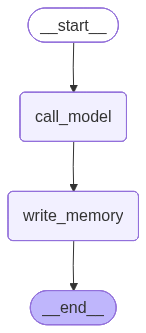

In [58]:
# Memory schema
class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")

# Create the Trustcall extractor
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    # This allows the extractor to insert new memories
    enable_inserts=True,
)

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot. You are designed to be a companion to a user. 

You have a long term memory which keeps track of information you learn about the user over time.

Current Memory (may include updated memories from this conversation): 

{memory}"""

# Trustcall instruction
TRUSTCALL_INSTRUCTION = """Reflect on following interaction. 

Use the provided tools to retain any necessary memories about the user. 

Use parallel tool calling to handle updates and insertions simultaneously:"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memories from the store and use them to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memories", user_id)
    memories = store.search(namespace)

    # Format the memories for the system prompt
    info = "\n".join(f"- {mem.value['content']}" for mem in memories)
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=info)

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("memories", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Memory"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    # merge_message_runs returns a generator, not a list.
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION)] + state["messages"]))

    # Invoke the extractor
    result = trustcall_extractor.invoke({"messages": updated_messages, 
                                        "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [62]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Lance")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

Hi again, Lance! How's your day going so far?


In [63]:
# User input 
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

That sounds like a lot of fun! San Francisco has some great biking routes. Do you have a favorite trail or area you like to explore?


In [64]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memories", user_id)
memories = across_thread_memory.search(namespace)
for m in memories:
    print(m.dict())

{'namespace': ['memories', '1'], 'key': 'fb60cf2e-ec1b-4937-9663-312aa8ec1d6b', 'value': {'content': 'User likes to bike around San Francisco.'}, 'created_at': '2025-10-23T10:10:28.353800+00:00', 'updated_at': '2025-10-23T10:10:28.353800+00:00', 'score': None}
{'namespace': ['memories', '1'], 'key': '5b580449-ec12-4de9-9f2c-bbb013ad1dec', 'value': {'content': 'User likes to bike around San Francisco.'}, 'created_at': '2025-10-23T10:10:28.353800+00:00', 'updated_at': '2025-10-23T10:10:28.353800+00:00', 'score': None}


In [65]:
# User input 
input_messages = [HumanMessage(content="I also enjoy going to bakeries")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I also enjoy going to bakeries
================================== Ai Message ==================================

Biking and bakeries make a great combination! Do you have a favorite bakery in San Francisco, or are you still exploring different ones?


In [66]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="What bakeries do you recommend for me?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What bakeries do you recommend for me?
================================== Ai Message ==================================

Since you enjoy biking around San Francisco, you might like to visit some of these bakeries that are not only delicious but also offer a nice ride:

1. **Tartine Bakery** - Located in the Mission District, it's a classic spot known for its bread and pastries. The area is bike-friendly, and you can enjoy a nice ride through the neighborhood.

2. **Arsicault Bakery** - Situated in the Richmond District, it's famous for its croissants. The ride there can be quite scenic, especially if you take a route through Golden Gate Park.

3. **B. Patisserie** - In Lower Pacific Heights, this bakery offers a variety of pastries and is known for its kouign-amann. The area is great for a leisurely bike ride.

4. **Mr. Holmes Bakehouse** - Located in the Tenderloin, it's known for its cruffins. The ride 